In [1]:
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../input"))


['train.csv.zip', 'test.csv', 'test.csv.zip', 'train.csv', 'sample_submission.csv.zip', 'sample_submission.csv', '.ipynb_checkpoints']


In [3]:
import mlxtend
import pandas_profiling

import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt


from tqdm import tqdm


/home/yuki/anaconda3/lib/python3.6/site-packages/pandas_profiling/plot.py:15: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/yuki/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/yuki/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/yuki/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/yuki/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.

In [4]:
%%time
train_df = pd.read_csv("../input/train.csv")


CPU times: user 2.7 s, sys: 114 ms, total: 2.82 s
Wall time: 9.14 s


In [5]:
train_df.shape

(4459, 4993)

In [6]:
TRAIN_SIZE = train_df.shape[0]

In [49]:
%%time
test_df = pd.read_csv("../input/test.csv", nrows=TRAIN_SIZE)
#test_df = pd.read_csv("../input/test.csv")


CPU times: user 3.27 s, sys: 32.7 ms, total: 3.31 s
Wall time: 3.3 s


# defining useful functions

In [8]:

%matplotlib inline

import os

import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew #for some statistics

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import learning_curve

import mlxtend
from mlxtend.plotting import plot_learning_curves

import pandas_profiling





def checkNaValues(dataframe):
    """check nan values in dataframe"""
    
    print("\n# Is there any nan values?: ", dataframe.isna().all().all())
    
    print("## detail missing data ratio")
    #if dataframe.isna().all().all()
    dataframe_na = (dataframe.isna().sum()/len(dataframe))*100
    print(dataframe_na)
    dataframe_na = dataframe_na.drop(
        dataframe_na[dataframe_na == 0].index
    ).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio':dataframe_na})
    print(missing_data)
    
    
    """there is error. so not implemented yet
    # just plot the rate
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=dataframe_na.index, y=dataframe_na.values)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    """

    
def checkObjTypeColumns(dataframe):
    """Check object dtype columns"""

    print("\n# object dtype columns")
    # object dtypeの列名からその列のデータのみを抽出
    df_object_type = dataframe[dataframe.select_dtypes(['object']).columns]
    #df_object_type = dataframe[[x for x in dataframe.columns if dataframe[x].dtypes == "object"]]
    print(df_object_type.head())
    #print(df_object_type.info()) # not useful info
    print(df_object_type.describe())

    
def checkValueCounts(dataframe):
    """check value counts of each features and find boolean feature or not."""

    print("# value_counts of each feature: ")
    for column in dataframe.columns:
        #print("## ", column, ": ")
        #print(dataframe[column].value_counts().head())
        value_counts = dataframe[column].value_counts().shape[0]
        if value_counts == 1:
            print(column, " -> single value. value count:  ", dataframe[column].value_counts().shape[0])            
        elif value_counts == 2:
            print(column, " -> maybe boolean. value count:  ", dataframe[column].value_counts().shape[0])
        else:
            print(column, " -> not boolean. value count:  ", dataframe[column].value_counts().shape[0])
            

def findSingleValueColmuns(dataframe):
    """check value counts of each features and find single value feature.
    Such column is no meaning to learn.
    """

    single_val_columns = []
    for column in dataframe.columns:
        value_counts = dataframe[column].value_counts().shape[0]
        if value_counts == 1:
            single_val_columns.append(column)
    return single_val_columns

            
def checkCorrelationOfFeatures(dataframe):
    """check correlation matix of each features"""

    # plot corr
    print("\n# correlation matrix")
    corrmat = dataframe.corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True)
    plt.show()
    print(corrmat)
    print()
    
    corr_values = corrmat.iloc[0]
    print("## highest correlation: ", corr_values.sort_values().head())
    print("## lowest correlation: ", corr_values.sort_values().tail())

    
def checkSkewness(dataframe):
    """check skewness of each features"""
    
    #numeric_feats = dataframe.dtypes[all_data.dtypes != "object"].index
    numeric_feats = dataframe.select_dtypes(exclude=['object'])
    #print(numeric_feats)
    # Check the skew of all numerical features
    skewed_feats = numeric_feats.apply(
        lambda x: skew(x.dropna())).sort_values(ascending=False)
    print("\n# Skew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print(skewness)
    
    return skewness
    
    
def checkAllDataInfo(dataframe):
    """print all dataframe info"""

    print(dataframe.head())
    print("\n# shape: ", dataframe.shape)
    print("\n# columns names: ", train_df.columns.values)
    
    print("\n# df.info(): ")
    print(dataframe.info())
    #print("\n# counts dtypes: \n", dataframe.dtypes.value_counts())# it is included in dataframe.info()

    print("\n# df.describe(): ")
    print(dataframe.describe())
    print()
    
    #print()
    #pandas_profiling.ProfileReport(dataframe)
    print()
    checkNaValues(dataframe)
    print()
    checkObjTypeColumns(dataframe)
    print()
    checkValueCounts(dataframe)
    print()
    #checkCorrelationOfFeatures(dataframe)
    
    print()
    checkSkewness(dataframe)
    
    
    
def my_plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        scoring="r2",
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



def checkTargetInfo(dataframe, target_name="y"):
    """print target y value info"""
 
    # plot distribution
    sns.distplot(train_df[target_name], fit=norm)
    (mu, sigma) = norm.fit(train_df[target_name])
    print("mu, sigma:", mu, sigma)

    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title('target value distribution')

    
    # plot skewness

    #print("skewness of y", skew(dataframe[target_name]))
    print("skewness of y", train_df[target_name].skew())
    fig = plt.figure()
    res = stats.probplot(train_df[target_name], plot=plt)
    plt.show()

    
    
def checkCorrelationOfSelectedFeatures(dataframe, columns):
    """check correlation matix of each features"""

    # plot corr
    print("\n# correlation matrix")
    corrmat = dataframe[columns].corr()
    plt.subplots(figsize=(12,9))
    sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)
    plt.show()
    print(corrmat)
    

    
def splitToIdTargetFeatures(dataframe, id_name, target_name):
    """split train df to data, id and taret dataframes
    """
    id_df = dataframe[id_name]
    target_df = dataframe[target_name]
    features_df = dataframe.drop([id_name, target_name], axis=1)
    
    return id_df, target_df, features_df




# EDA

## general info

## checking in details

## checkTargetInfo

### apply logarithm transformation to tareget

14.490239292748585 1.7507504829494496


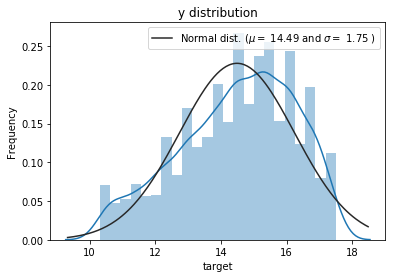

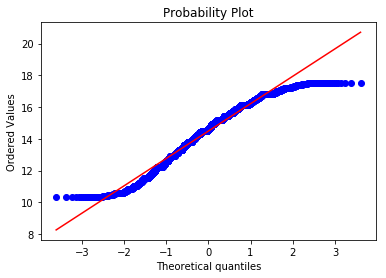

In [9]:
# apply logarithm transformation

train_df["target"] = np.log1p(train_df["target"])
sns.distplot(train_df["target"], fit=norm)

(mu, sigma) = norm.fit(train_df["target"])
print(mu, sigma)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('y distribution')

fig = plt.figure()
res = stats.probplot(train_df["target"], plot=plt)
plt.show()


## pairplot

- not good idea to make function
- better to use pairplot() directly. more useful.

## pandas_profiling

----

# feature eng

## add some features before drop some columns


### add sum of zeros feature

In [10]:
def add_SumZeros(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    train.insert(1, 'SumZeros', (train[flist] == 0).astype(int).sum(axis=1))
    test.insert(1, 'SumZeros', (test[flist] == 0).astype(int).sum(axis=1))
    return train, test


In [11]:
%%time
train_df, test_df = add_SumZeros(train_df, test_df)


CPU times: user 5.51 s, sys: 1.28 s, total: 6.8 s
Wall time: 6.94 s


In [12]:
train_df.SumZeros.head()

0    4889
1    4924
2    4973
3    4969
4    4965
Name: SumZeros, dtype: int64

In [13]:
test_df.SumZeros.head()

0    4913
1    4979
2    4892
3    4871
4    4983
Name: SumZeros, dtype: int64

### add sum of values

In [14]:
def add_SumValues(train, test):
    flist = [x for x in train.columns if not x in ['ID','target']]
    
    train.insert(1, 'SumValues', (train[flist] != 0).astype(int).sum(axis=1))
    test.insert(1, 'SumValues', (test[flist] != 0).astype(int).sum(axis=1))

    return train, test

In [15]:
%%time
train_df, test_df = add_SumValues(train_df, test_df)


CPU times: user 5.45 s, sys: 1.35 s, total: 6.8 s
Wall time: 6.84 s


In [16]:
train_df.SumValues.head()

0    103
1     68
2     19
3     23
4     27
Name: SumValues, dtype: int64

In [17]:
test_df.SumValues.head()

0     79
1     13
2    100
3    121
4      9
Name: SumValues, dtype: int64

## add other Aggregates

In [18]:
other_agg_list = ['Mean', 'Median', 'Mode', 'Max', 'Var', 'Std']

def add_OtherAgg(train, test):
    flist = [x for x in train.columns if not x in ['ID','target','SumZeros','SumValues']]
    train['Mean']   = train[flist].mean(axis=1)
    train['Median'] = train[flist].median(axis=1)
    train['Mode']   = train[flist].mode(axis=1)
    train['Max']    = train[flist].max(axis=1)
    train['Var']    = train[flist].var(axis=1)
    train['Std']    = train[flist].std(axis=1)

    test['Mean']   = test[flist].mean(axis=1)
    test['Median'] = test[flist].median(axis=1)
    test['Mode']   = test[flist].mode(axis=1)
    test['Max']    = test[flist].max(axis=1)
    test['Var']    = test[flist].var(axis=1)
    test['Std']    = test[flist].std(axis=1)

    return train, test

In [19]:
%%time
train_df, test_df = add_OtherAgg(train_df, test_df)


CPU times: user 1min 8s, sys: 8.51 s, total: 1min 16s
Wall time: 1min 16s


In [20]:
train_df[other_agg_list].head()

,Mean,Median,Mode,Max,Var,Std
0,144413.611164,0.0,0.0,40000000.0,3.031989e+12,1.741261e+06
1,106585.186672,0.0,0.0,50000000.0,2.338739e+12,1.529294e+06
2,15267.481467,0.0,0.0,12000000.0,1.098310e+11,3.314076e+05
3,6690.175648,0.0,0.0,6000000.0,3.020618e+10,1.737993e+05
4,35803.245843,0.0,0.0,37662000.0,7.195723e+11,8.482761e+05


In [21]:
test_df[other_agg_list].head()

,Mean,Median,Mode,Max,Var,Std
0,442863.226849,0.0,0.0,9.605043e+08,2.064611e+14,1.436875e+07
1,18463.769828,0.0,0.0,3.176478e+07,3.714398e+11,6.094586e+05
2,117647.532959,0.0,0.0,8.000000e+07,3.293080e+12,1.814684e+06
3,354811.979455,0.0,0.0,1.000000e+08,9.775059e+12,3.126509e+06
4,26661.551225,0.0,0.0,1.077087e+08,2.354338e+12,1.534385e+06


In [22]:
added_cols_pls_target = ["target", 'SumZeros', 'SumValues']+other_agg_list
train_df[added_cols_pls_target].head()

,target,SumZeros,SumValues,Mean,Median,Mode,Max,Var,Std
0,17.453097,4889,103,144413.611164,0.0,0.0,40000000.0,3.031989e+12,1.741261e+06
1,13.304687,4924,68,106585.186672,0.0,0.0,50000000.0,2.338739e+12,1.529294e+06
2,16.118096,4973,19,15267.481467,0.0,0.0,12000000.0,1.098310e+11,3.314076e+05
3,14.508658,4969,23,6690.175648,0.0,0.0,6000000.0,3.020618e+10,1.737993e+05
4,16.482739,4965,27,35803.245843,0.0,0.0,37662000.0,7.195723e+11,8.482761e+05


In [23]:
corr = train_df[added_cols_pls_target].corr()
corr

,target,SumZeros,SumValues,Mean,Median,Mode,Max,Var,Std
target,1.000000,0.050515,-0.050515,0.206092,NaN,NaN,0.034356,-0.013170,0.137552
SumZeros,0.050515,1.000000,-1.000000,-0.659386,NaN,NaN,-0.173976,-0.119944,-0.389526
SumValues,-0.050515,-1.000000,1.000000,0.659386,NaN,NaN,0.173976,0.119944,0.389526
Mean,0.206092,-0.659386,0.659386,1.000000,NaN,NaN,0.326719,0.274386,0.691474
Median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Max,0.034356,-0.173976,0.173976,0.326719,NaN,NaN,1.000000,0.947440,0.891486
Var,-0.013170,-0.119944,0.119944,0.274386,NaN,NaN,0.947440,1.000000,0.814261
Std,0.137552,-0.389526,0.389526,0.691474,NaN,NaN,0.891486,0.814261,1.000000


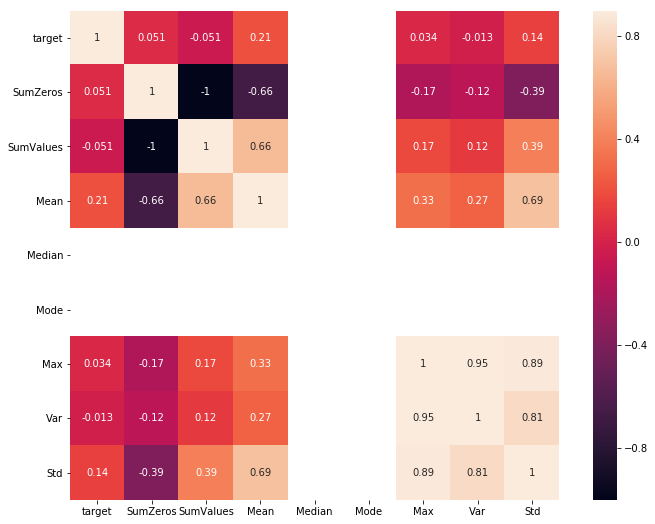

In [24]:
plt.subplots(figsize=(12,9))
sns.heatmap(corr, vmax=0.9, square=True, annot=True)
plt.show()

## remove single value column

In [25]:
single_val_columns = findSingleValueColmuns(train_df)

In [26]:
print("drop single value columns, ", len(single_val_columns), "columns were dropped")

drop single value columns,  258 columns were dropped


In [27]:
print("train_df.shape, test_df.shape")
print(train_df.shape, test_df.shape)

train_df.drop(single_val_columns, axis=1, inplace=True)
test_df.drop(single_val_columns, axis=1, inplace=True)

print(train_df.shape, test_df.shape)

train_df.shape, test_df.shape
(4459, 5001) (49342, 5000)
(4459, 4743) (49342, 4742)


## remove dupulicate column

remove if train_df data is same even if test_df data is not same.
because if train_df data is same, it cannot learn the differece.

comment out to reduce time

In [28]:
colsToRemove =  ['d60ddde1b', 'acc5b709d', 'f333a5f60', 'f8d75792f', '912836770', 'f333a5f60']
colsScaned =  ['d60ddde1b', 'acc5b709d', 'f333a5f60', 'f8d75792f', '912836770']
dupList =  {'34ceb0081': ['d60ddde1b'], '8d57e2749': ['acc5b709d', 'f333a5f60'], '168b3e5bc': ['f8d75792f'], 'a765da8bc': ['912836770']}

In [29]:
print("train_df.shape, test_df.shape")
print(train_df.shape, test_df.shape)

train_df.drop(colsToRemove, axis=1, inplace=True)
test_df.drop(colsToRemove, axis=1, inplace=True)

print(train_df.shape, test_df.shape)

train_df.shape, test_df.shape
(4459, 4743) (49342, 4742)
(4459, 4738) (49342, 4737)


## check Correlation and reduce high corr features

- if a feature have only one value, correlation become NAN.
- so better to check correlation after dropped one value features

## combine train/test to all_data

In [30]:
ntrain = train_df.shape[0]
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)

all_id, all_target, all_data = splitToIdTargetFeatures(all_data, id_name="ID", target_name="target")


In [31]:
all_data.head()

,001476ffa,0019109c4,0022de2b3,0024cd760,002d634dc,00302fe51,003da5628,006e72749,007d71f12,007ee91d1,...,ffa45bf70,ffa6b80e2,ffa903344,ffb34b926,ffca57b7b,ffcec956f,ffd2f9409,ffd50f0bf,ffdc4bcf8,ffec49dae
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
all_id.head()

0    000d6aaf2
1    000fbd867
2    0027d6b71
3    0028cbf45
4    002a68644
Name: ID, dtype: object

In [33]:
all_target.head()

0    17.453097
1    13.304687
2    16.118096
3    14.508658
4    16.482739
Name: target, dtype: float64

## skew feature

In [34]:
skewness = checkSkewness(all_data)
skewness.head(5)


# Skew in numerical features: 

                 Skew
55e30b08f  230.972695
455b51392  230.303813
28690ae0d  229.500405
470cea05f  228.828795
1614f0f84  228.321276
39896d3dd  228.283309
ed0860a34  228.027306
fe33df1c4  227.844080
f7f2e3896  227.770747
5c7eb01b4  227.529761
940c3b22f  227.508794
ba480f343  227.433911
3be4dad48  226.675191
6eebf3ca4  226.649999
2b85882ad  226.363073
6dcac05e7  226.121022
b3bfbc1fa  225.886324
5878b703c  225.658195
e9f57e5c6  225.650265
e325dec5e  225.598943
9685f5e16  225.467673
1b41a7ee2  225.438692
95bbebdd4  225.083708
907e76fa9  225.064555
8706aa459  224.786776
cf3841208  224.726568
e2c21c4bc  224.713659
07cb6041d  224.652034
625525b5d  223.478113
bf8150471  223.452716
...               ...
324921c7b   12.396595
02861e414   12.310006
f02ecb19c   12.288267
70feb1494   12.160715
20aa07010   12.081955
5c6487af1   11.971548
1702b5bf0   11.822818
58e056e12   11.784932
58e2e02e6   11.678142
b43a7cfd5   11.549897
024c577b9   11.488526
58232a6fb   11.405308

,Skew
55e30b08f,230.972695
455b51392,230.303813
28690ae0d,229.500405
470cea05f,228.828795
1614f0f84,228.321276


In [35]:
skewness.tail(5)

,Skew
f190486d6,9.356704
Std,7.608630
SumValues,4.782394
Mean,4.318135
SumZeros,-4.782394


## Box Cox Transformation of (highly) skewed features



In [36]:
skewnessBig = skewness[abs(skewness) > 0.75]
print("feature num {}\nskewed feature number: {}".format(skewness.shape[0], 
                                                         skewnessBig.shape[0]))

from scipy.special import boxcox1p

skewed_features = skewnessBig.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)


feature num 4736
skewed feature number: 4736


In [37]:
all_data.apply(
    lambda x: skew(x.dropna())).sort_values(ascending=False)

76c1e9617    20.916623
770d3a11c    20.809959
969d32625    20.743804
73a32cd05    20.653370
ae82c2c99    20.505281
d0e4129cb    20.486538
5a1183b8c    20.398902
1b6c8debf    20.355429
f30ab5791    20.321998
f9a30f20a    20.250894
05d95861b    20.139686
eeae7ad90    20.084553
f66c58ca7    20.067168
47d17d395    20.065222
2f0771a37    20.063393
59de861ff    20.055486
2ce7f870e    20.051543
7cc424ffd    20.036406
a77d3eb03    20.020546
8c00634d1    20.008166
8d57e2749    19.982841
1b48a4b5b    19.976724
38a5a3497    19.952202
0c5eaf8a7    19.914078
96fec9b38    19.910162
c6d27ddbb    19.870155
bacadce94    19.858987
de23dceb1    19.847348
f49c1d119    19.829011
cf6038b0f    19.825276
               ...    
26fc93eb7     2.356486
963a49cdc     2.344261
5c6487af1     2.320992
66ace2992     2.317843
f74e8f13d     2.310005
241f0f867     2.294695
2ec5b290f     2.285333
fb49e4212     2.279526
62e59a501     2.278538
d6bb78916     2.258060
b43a7cfd5     2.252335
324921c7b     2.250519
58232a6fb  

----

# prepare train/test data

In [38]:
id_train_df, y_train_df, X_train_df = splitToIdTargetFeatures(train_df,
                                                              id_name="ID",
                                                              target_name="target")

In [39]:
print(id_train_df.head())
print(y_train_df.head())
print(X_train_df.head())

0    000d6aaf2
1    000fbd867
2    0027d6b71
3    0028cbf45
4    002a68644
Name: ID, dtype: object
0    17.453097
1    13.304687
2    16.118096
3    14.508658
4    16.482739
Name: target, dtype: float64
   SumValues  SumZeros  48df886f9  0deb4b6a8  34b15f335  a8cb14b00  2f0771a37  \
0        103      4889        0.0          0        0.0          0          0   
1         68      4924        0.0          0        0.0          0          0   
2         19      4973        0.0          0        0.0          0          0   
3         23      4969        0.0          0        0.0          0          0   
4         27      4965        0.0          0        0.0          0          0   

   30347e683  d08d1fbe3  6ee66e115      ...       f677d4d13  71b203550  \
0          0          0          0      ...               0          0   
1          0          0          0      ...               0          0   
2          0          0          0      ...               0          0   
3          0  

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, y_train_df, 
    test_size=0.33, random_state=42)
print("train/test data shape", X_train.shape, X_test.shape)


train/test data shape (2987, 4736) (1472, 4736)


# base model

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA

from hyperopt import hp, tpe, Trials, fmin

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

from mlxtend.regressor import StackingRegressor

## Defined find best parameter function by hyperopt module

### give model for hyperopt my funcs

In [42]:
count_hyperopt = 0

def hyperopt_objective(model, X_train, y_train, scoring="neg_mean_squared_log_error", cv_size=5, n_jobs=3):
    """return objective function for hyperopt"""

    def objective(args):
        global count_hyperopt
        print("Trial ", count_hyperopt, ", Params ", args, " -> ", end="")
        
#        print(model.steps[-1])
        model.steps[-1][1].set_params(**args)

        score = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv_size, n_jobs=n_jobs)
        
        print("Done. Score : ", np.sqrt(-score.mean()))
        count_hyperopt += 1
  
        return np.sqrt(-score.mean())

    return objective





def searchHyperParam(model, par_space, X_train, y_train, scoring="r2", max_evals=100, cv_size=5, n_jobs=3):
    """search hyper parameter of a selected model"""

    
    global count_hyperopt
    count_hyperopt = 0
    
    objective = hyperopt_objective(model, X_train, y_train, scoring=scoring, cv_size=cv_size, n_jobs=n_jobs)
    
    #best_params = findBestParm(objective, par_space, X_train, y_train, scoring=scoring, max_evals=max_evals)

    trials = Trials()

    best = fmin(
        objective, 
        par_space, # 探索するパラメータのdictもしくはlist
        algo=tpe.suggest, # どのロジックを利用するか、基本的にはtpe.suggestでok
        max_evals=max_evals,
        trials=trials,
        #verbose=1
    )
    print("best par: ", best)
    print("best trial: ", trials.best_trial["result"])
    #print("trials losses: ", trials.losses())

    count_hyperopt = 0
    
    return best


def evalModelByCV(model, X_train, y_train, scoring="neg_mean_squared_log_error"):
    """evaluate model by cross validation"""
    
    score = cross_val_score(model, X_train, y_train, scoring=scoring, cv=5)

    print("model score: {:f} ({:f})\n" .format(
        score.mean(), score.std()))
    print("all scores: ", score)

    
def plot_my_learning_curves(X_train, y_train, X_test, y_test, model, scoring="r2", cv=5, n_jobs=3):
    """plot learning curves by mlxtend and my func my_plot_learning_curve()"""
    plot_learning_curves(X_train, y_train, X_test, y_test, 
                     model, scoring=scoring)
    plt.show()
    
    title = "Learning Curves"
    my_plot_learning_curve(model, title, 
                        X_train, y_train,
                        #ylim=(0.7, 1.01), 
                        cv=cv, scoring=scoring,
                        n_jobs=n_jobs)
    plt.show()

    
    

## Def hyperopt param

In [43]:
cv_size = 5
#max_evals = 100
max_evals = 5
n_jobs = 1

## SVR

In [44]:
svr = make_pipeline(
    PCA(n_components=0.95),
    RobustScaler(),
    SVR()

)

kernel_list = [
    'rbf',
#    'poly',
    'sigmoid']
par_space = {
    'C':hp.loguniform('C', -8, 2),
    'gamma':hp.loguniform('gamma', -8, 2),
    'epsilon':hp.loguniform('epsilon', -8, 2),
    'kernel':hp.choice('kernel', kernel_list)
}


In [45]:
%%time
best_params = searchHyperParam(svr, par_space, X_train, y_train, scoring="neg_mean_squared_log_error", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params["kernel"] = kernel_list[best_params["kernel"]]
print(best_params)


Trial  0 , Params  {'C': 0.015606825347517209, 'epsilon': 0.048621037112302805, 'gamma': 0.0004059625558063999, 'kernel': 'rbf'}  -> Done. Score :  0.11793265035176852
Trial  1 , Params  {'C': 0.8073700148905972, 'epsilon': 0.0005044200583732534, 'gamma': 0.03554052840314313, 'kernel': 'rbf'}  -> Done. Score :  0.11605478021767193
Trial  2 , Params  {'C': 0.47979534005634844, 'epsilon': 0.6727560734139717, 'gamma': 0.0010798243888283706, 'kernel': 'rbf'}  -> Done. Score :  0.11639569861245305
Trial  3 , Params  {'C': 0.014846724295992077, 'epsilon': 5.345791733860511, 'gamma': 0.10532786015529337, 'kernel': 'rbf'}  -> Done. Score :  0.12163528322607522
Trial  4 , Params  {'C': 0.014065581834605894, 'epsilon': 0.037762648561570446, 'gamma': 0.0015116606744662823, 'kernel': 'rbf'}  -> Done. Score :  0.11748717511181846
best par:  {'C': 0.8073700148905972, 'epsilon': 0.0005044200583732534, 'gamma': 0.03554052840314313, 'kernel': 0}
best trial:  {'loss': 0.11605478021767193, 'status': 'ok'

In [54]:
best_params = {'C': 6.0125849233435975,
 'epsilon': 0.018596343856883617,
 'gamma': 0.019396603678872793,
 'kernel': 'rbf'}

In [62]:
svr.steps[-1][1].set_params(**best_params)

evalModelByCV(svr, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, svr, scoring="r2", cv=5, n_jobs=n_jobs)

model score: -0.011961 (0.000356)

all scores:  [-0.01166458 -0.01221713 -0.01244525 -0.0120098  -0.01146622]


## lasso

In [47]:
lasso = make_pipeline(
    RobustScaler(),
    Lasso()

)

par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    
}

In [48]:
best_params = {'alpha': 0.03813148491610924}

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

model score: -199180.829195 (183107.567417)

all scores:  [-119732.15576148  -33358.78359539 -551779.302959   -102229.79125074
 -188804.11240854]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

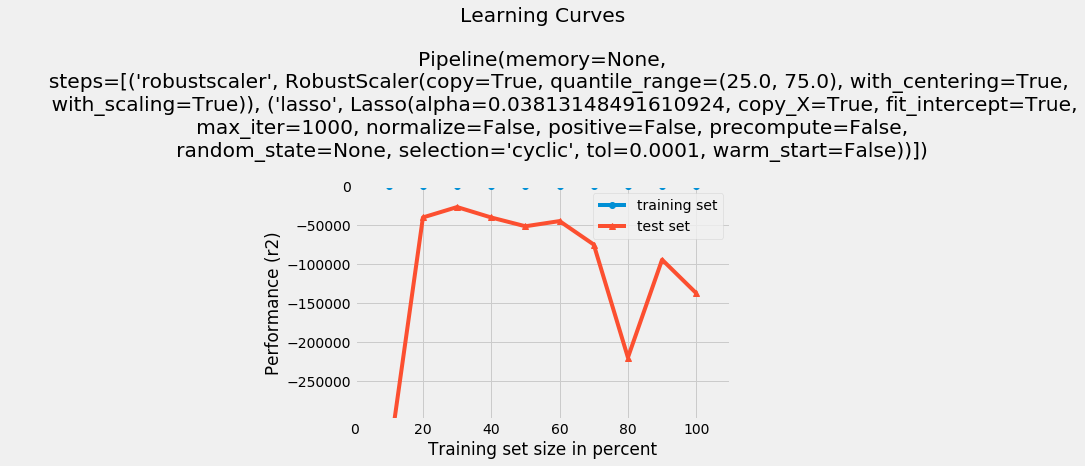

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

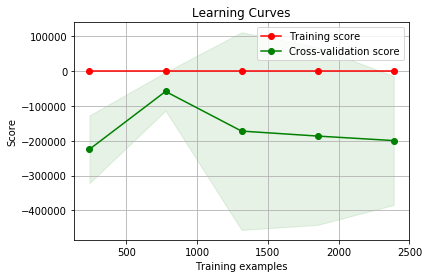

In [49]:

lasso.steps[-1][1].set_params(**best_params)

evalModelByCV(lasso, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, lasso, scoring="r2", cv=5, n_jobs=n_jobs)

## Elastic net

In [50]:
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNet()

)
par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    'l1_ratio':hp.uniform('l1_ratio', 0, 1),
    
}

In [51]:
best_params = {'alpha': 0.03979354323226861, 'l1_ratio': 0.9027788528223015}

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

model score: -212195.536990 (181313.048460)

all scores:  [-119904.22921576  -35664.53200585 -553039.20117325 -121763.8839184
 -230605.83863828]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

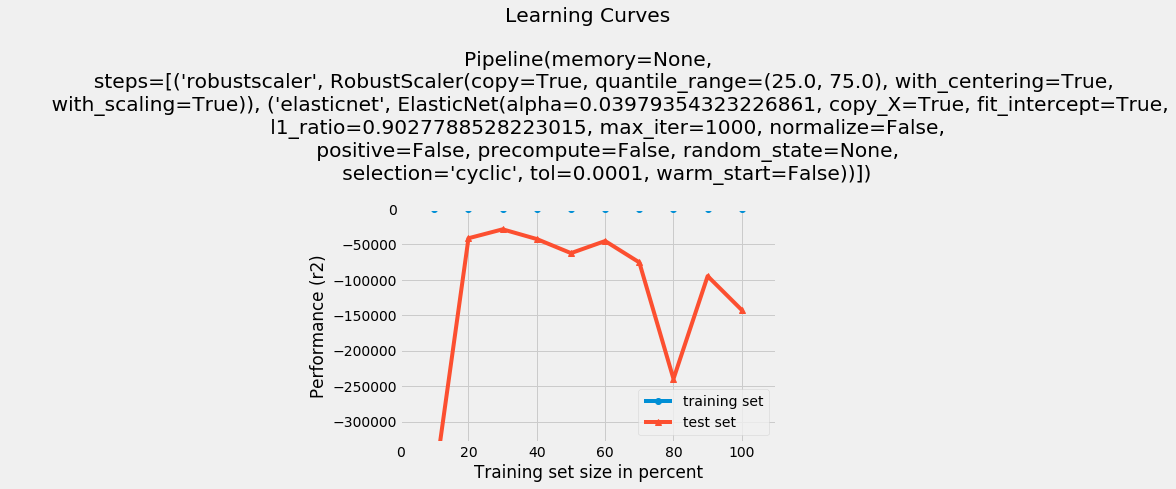

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

KeyboardInterrupt: 

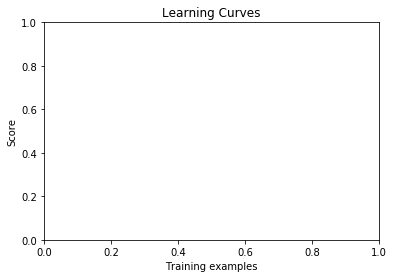

In [52]:

elasticnet.steps[-1][1].set_params(**best_params)

evalModelByCV(elasticnet, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, elasticnet, scoring="r2", cv=5, n_jobs=n_jobs)


## kernel ridge

In [ ]:
krr = make_pipeline(
        #RobustScaler(),
        KernelRidge()
)

kernel_list = [
    'rbf',
#    'poly',
    'sigmoid']
par_space = {
    'alpha':hp.uniform('alpha', 0, 1),
    'gamma':hp.loguniform('gamma', -8, 2),
    'kernel':hp.choice('kernel', kernel_list),
    'degree':hp.randint('degree', 5),
#    'coef0': # default value is enough
    
}

In [ ]:
best_params = {'alpha': 0.06208805100456642,
 'degree': 2,
 'gamma': 0.000700959885815984,
 'kernel': 'rbf'}

In [ ]:
krr.steps[-1][1].set_params(**best_params)

evalModelByCV(krr, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, krr, scoring="r2", cv=5, n_jobs=n_jobs)


## k neighbers

In [ ]:
knr = make_pipeline(
    #RobustScaler(),
    KNeighborsRegressor()
)

par_space = {
#    'n_neighbors':hp.choice('n_neighbors', [1,2,3,4,5,6,7,8,9,10]),
#    'n_neighbors':hp.quniform('n_neighbors', 1, 10, 1),
    'n_neighbors':hp.choice('n_neighbors', np.arange(1, 10, dtype=int))
#    'coef0': # default value is enough
    
}

In [ ]:
best_params = {'n_neighbors': 8}

In [ ]:
knr.steps[-1][1].set_params(**best_params)


evalModelByCV(knr, X_train, y_train, scoring="neg_mean_squared_log_error")

#plot_my_learning_curves(X_train, y_train, X_test, y_test, knr, scoring="r2", cv=5, n_jobs=n_jobs)

## Random forest

In [ ]:
ranfore = make_pipeline(
        #RobustScaler(),
        RandomForestRegressor()
)

par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_features':hp.choice('max_features', np.arange(1, 300, dtype=int)),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 10, dtype=int)),
    'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(1, 9, dtype=int)),   
}

In [ ]:
best_params = {'max_depth': 5,
 'max_features': 226,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'n_estimators': 56}

In [ ]:
ranfore.steps[-1][1].set_params(**best_params)

evalModelByCV(ranfore, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, ranfore, scoring="r2", cv=5, n_jobs=n_jobs)
# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(ranfore.named_steps["randomforestregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## gradient boosting

In [ ]:
gboostreg = make_pipeline(
        #RobustScaler(),
        GradientBoostingRegressor()
)

loss_list = ['ls', 'lad', 'huber', 'quantile']

par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_features':hp.choice('max_features', np.arange(1, 300, dtype=int)),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)),
    'min_samples_split':hp.choice('min_samples_split', np.arange(2, 30, dtype=int)),
    'min_samples_leaf':hp.choice('min_samples_leaf', np.arange(1, 29, dtype=int)),
    'loss':hp.choice('loss', loss_list),
    #'subsample':hp.uniform('learning_rate', 0.0, 1.0),
    
}


In [ ]:
best_params = {'learning_rate': 0.35189025799801155,
 'loss': 'huber',
 'max_depth': 3,
 'max_features': 119,
 'min_samples_leaf': 16,
 'min_samples_split': 19,
 'n_estimators': 48}

In [ ]:
gboostreg.steps[-1][1].set_params(**best_params)

evalModelByCV(gboostreg, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, gboostreg, scoring="r2", cv=5, n_jobs=n_jobs)
# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(gboostreg.named_steps["gradientboostingregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## XGBoost

In [ ]:
xgbmodel = make_pipeline(
        #RobustScaler(),
        XGBRegressor()
)


par_space = {
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), 
    'gamma':hp.uniform('gamma', 0.0, 5.0),
    'min_child_weight':hp.uniform('min_child_weight', 0.0, 5.0),
    'subsample': hp.uniform('subsample', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.0, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -6, 2),
    'reg_lambda': hp.loguniform('reg_lambda', -6, 2),
    'learning_rate': hp.uniform('learning_rate', 0.000000001, 1.0),
}

In [ ]:
best_params = {'colsample_bytree': 0.4708332878894328,
 'gamma': 4.468853259609137,
 'learning_rate': 0.05617427300476756,
 'max_depth': 227,
 'min_child_weight': 1.8959293704519609,
 'n_estimators': 69,
 'reg_alpha': 0.011073130482133953,
 'reg_lambda': 0.00429738591644784,
 'subsample': 0.034785099220768445}

In [ ]:
xgbmodel.steps[-1][1].set_params(**best_params)

evalModelByCV(xgbmodel, X_train, y_train, scoring="neg_mean_squared_log_error")
#plot_my_learning_curves(X_train, y_train, X_test, y_test, xgbmodel, scoring="r2", cv=5, n_jobs=n_jobs)


xgb.plot_importance(xgbmodel.named_steps["xgbregressor"], max_num_features=15)
plt.show()

# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(xgbmodel.named_steps["xgbregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

## LightGBM

In [46]:
lgbmodel = make_pipeline(
        #RobustScaler(),
        LGBMRegressor()
)

par_space = {
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 30, dtype=int)), 
    'num_leaves':hp.choice('num_leaves', np.arange(2, 10, dtype=int)),
    'min_data_in_leaf':hp.choice('min_data_in_leaf', np.arange(1, 10, dtype=int)),
    
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_bin':hp.choice('max_bin', np.arange(2, 30, dtype=int)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.000000001, 1.0),
    'bagging_freq': hp.randint('bagging_freq', 10),
    'feature_fraction': hp.uniform('feature_fraction', 0.000000001, 1.0),
    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -6, 2),
}

"""
par_space = {
    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),
    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), 
    'num_leaves':hp.choice('num_leaves', np.arange(2, 100, dtype=int)),
    'min_data_in_leaf':hp.choice('min_data_in_leaf', np.arange(1, 100, dtype=int)),
    
    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),
    'max_bin':hp.choice('max_bin', np.arange(2, 300, dtype=int)),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.000000001, 1.0),
    'bagging_freq': hp.randint('bagging_freq', 10),
    'feature_fraction': hp.uniform('feature_fraction', 0.000000001, 1.0),
    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -6, 2),
}
"""

"\npar_space = {\n    'learning_rate':hp.uniform('learning_rate', 0.000000001, 1.0),\n    'max_depth':hp.choice('max_depth', np.arange(1, 300, dtype=int)), \n    'num_leaves':hp.choice('num_leaves', np.arange(2, 100, dtype=int)),\n    'min_data_in_leaf':hp.choice('min_data_in_leaf', np.arange(1, 100, dtype=int)),\n    \n    'n_estimators':hp.choice('n_estimators', np.arange(1, 100, dtype=int)),\n    'max_bin':hp.choice('max_bin', np.arange(2, 300, dtype=int)),\n    'bagging_fraction': hp.uniform('bagging_fraction', 0.000000001, 1.0),\n    'bagging_freq': hp.randint('bagging_freq', 10),\n    'feature_fraction': hp.uniform('feature_fraction', 0.000000001, 1.0),\n    'min_sum_hessian_in_leaf': hp.loguniform('min_sum_hessian_in_leaf', -6, 2),\n}\n"

In [48]:
%%time
cv_size = 5
max_evals = 100
n_jobs = 1

best_params = searchHyperParam(lgbmodel, par_space, X_train, y_train, scoring="neg_mean_squared_log_error", max_evals=max_evals, cv_size=cv_size, n_jobs=n_jobs)
best_params

Trial  0 , Params  {'bagging_fraction': 0.6734287821728483, 'bagging_freq': 9, 'feature_fraction': 0.39389772321019206, 'learning_rate': 0.5584019549326337, 'max_bin': 3, 'max_depth': 23, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1.2592075432082916, 'n_estimators': 12, 'num_leaves': 7}  -> Done. Score :  0.10632170393838551
Trial  1 , Params  {'bagging_fraction': 0.594861076897536, 'bagging_freq': 1, 'feature_fraction': 0.9328906068211329, 'learning_rate': 0.2465013265654122, 'max_bin': 18, 'max_depth': 18, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 4.601474939847675, 'n_estimators': 19, 'num_leaves': 5}  -> Done. Score :  0.0979548781529151
Trial  2 , Params  {'bagging_fraction': 0.9147219819894942, 'bagging_freq': 2, 'feature_fraction': 0.16877049406971675, 'learning_rate': 0.8424062675344378, 'max_bin': 23, 'max_depth': 6, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 0.039886999338241795, 'n_estimators': 79, 'num_leaves': 5}  -> Done. Score :  0.11260776647262136

/home/yuki/.local/lib/python3.6/site-packages/sklearn/metrics/regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# used 100 max_evalus score

best_params = {'bagging_fraction': 0.6488366999217055,
 'bagging_freq': 4,
 'feature_fraction': 0.8769912726752449,
 'learning_rate': 0.2322285924856258,
 'max_bin': 259,
 'max_depth': 46,
 'min_data_in_leaf': 34,
 'min_sum_hessian_in_leaf': 0.011853166137307664,
 'n_estimators': 54,
 'num_leaves': 3}

In [ ]:
lgbmodel.steps[-1][1].set_params(**best_params)


evalModelByCV(lgbmodel, X_train, y_train, scoring="neg_mean_squared_log_error")


#plot_my_learning_curves(X_train, y_train, X_test, y_test, lgbmodel, scoring="r2", cv=5, n_jobs=3)

# plot feature importance
pd.concat((pd.DataFrame(X_train.columns, columns = ['variable']), 
           pd.DataFrame(lgbmodel.named_steps["lgbmregressor"].feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)


## catboost

## TPOT


# Stacking

In [ ]:
# svr, lasso, elasticnet, krr, knr, ranfore, gboostreg, xgbmodel

stregr = StackingRegressor(regressors=[
    svr,
    lasso, 
    #elasticnet, 
    #krr, 
    #knr, 
    ranfore, 
    gboostreg, 
    xgbmodel,
    lgbmodel,
],
                           meta_regressor=elasticnet)


evalModelByCV(stregr, X_train, y_train, scoring="neg_mean_squared_log_error")


#plot_my_learning_curves(X_train, y_train, X_test, y_test, stregr, scoring="r2", cv=5, n_jobs=n_jobs)



In [ ]:
# https://rasbt.github.io/mlxtend/api_subpackages/mlxtend.regressor/
stregr.coef_

In [ ]:
# Training the stacking classifier with all train data

stregr.fit(train_df, y_train_df)

# Make submission file


In [ ]:
sub = pd.DataFrame()
sub['ID'] = id_test_df
sub['target'] = np.expm1(stregr.predict(test_df))
sub.to_csv('../output/submission.csv', index=False)
